In [183]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [184]:
NUM_CLUSTERS = 3
KERNEL_SIZE = 23
STOP_DIST = 70
ATTEMPTS = 20
DIR = 'processed_images'

In [185]:
id = 4540
original_images = []
original_images.append(cv2.imread(f'cropped_images/IMG_{id}.JPG'))
processed_images = original_images.copy()

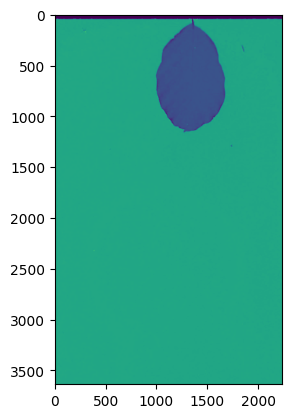

In [ ]:
plt.imshow(processed_images[0])

In [187]:
def extract_channels(images):
    for idx, img in enumerate(images):
        img_hsv = extract_HSV_channel(img)
        images[idx] = extract_H_channel(img_hsv)

def extract_HSV_channel(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def extract_H_channel(img_hsv):
    return img_hsv[:, :, 0]

In [188]:
extract_channels(processed_images)
processed_images[0].shape

(3638, 2236)

plt.figure(figsize=(10, 10), dpi=50)
plt.imshow(processed_images[0])
plt.axis('off')
plt.show()

In [189]:
def clustering_mask(img, num_clusters):
    labels_reshaped = kmeans_plusplus(img, num_clusters)
    return second_largest_cluster_mask(labels_reshaped, num_clusters)

def kmeans_plusplus(img, num_clusters): 
    pixel_values = np.float32(img.flatten())
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, num_clusters, None, criteria, ATTEMPTS, cv2.KMEANS_PP_CENTERS)
    # _, labels, centers = cv2.kmeans(pixel_values, num_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    labels_reshaped = labels.reshape(img.shape)
    return labels_reshaped

def second_largest_cluster_mask(labels_reshaped, num_clusters):
    masks = [cv2.inRange(labels_reshaped, cluster_id, cluster_id) for cluster_id in range(num_clusters)]
    sizes = [cv2.countNonZero(mask) for mask in masks]
    print(sizes)
    second_largest_cluster_mask = masks[sorted(zip(sizes, range(num_clusters)), reverse=True)[1][1]]
    return masks # second_largest_cluster_mask

In [190]:
def largest_component_mask(mask):
        mask = np.uint8(mask)
        _, components = cv2.connectedComponents(mask, connectivity=8)
        return np.uint8(components == np.argmax(np.bincount(components.flat)[1:]) + 1) * 255

In [191]:
def apply_mask(img, mask):
    return cv2.bitwise_and(img, img, mask=mask)

In [192]:
def stem_cutted_mask(mask, masked_img, stop_distance, kernel_size):
    gray = rgb_to_gray(masked_img)
    binary_img = gray_to_binary(masked_img)

    start_row = None  # Initialize the starting row of the stem
    end_row = None  # Initialize the ending row of the stem

    for row in range(binary_img.shape[0]):  # Scan image from top to bottom
        current_row = binary_img[row, :]
        non_zero_indices = np.nonzero(current_row)[0]
        
        if non_zero_indices.size > 0:
            if start_row is None:  # If this is the first row with non-zero elements, mark it as the start of the stem
                start_row = row
                
            pixel_distance = np.max(non_zero_indices) - np.min(non_zero_indices)  # Calculate the pixel distance
            
            if pixel_distance > stop_distance:  # If the pixel distance exceeds the stop distance, mark this row as the end of the stem and break the loop
                end_row = row
                break

    if (start_row is not None and end_row is not None and start_row < end_row) or start_row != 0:
        print(f"Start row: {start_row}, End row: {end_row}")  # Print out start and end rows
        stem_region = gray[start_row:end_row, :]
        blurred_stem = cv2.medianBlur(stem_region, kernel_size)  # Apply a median blur to the stem region
        
        gray_after_blur = np.vstack((gray[:start_row, :], blurred_stem, gray[end_row:, :]))  # Reconstruct the image after blurring
    else:
        print("Applying blur to the first 10 of the image")
        gray_after_blur = gray

    _, mask = cv2.threshold(gray_after_blur, 1, 255, cv2.THRESH_BINARY)  # Convert the gray_after_blur to a binary mask
    return mask
    
def median_blur(stem_region, kernel_size):
    return cv2.medianBlur(stem_region, kernel_size)

def gray_to_binary(img):
    gray_img = rgb_to_gray(img)
    _, binary_img = cv2.threshold(gray_img, 1, 255, cv2.THRESH_BINARY)
    return binary_img

def rgb_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [193]:
cm = clustering_mask(processed_images[0], NUM_CLUSTERS)[1]
lcm = largest_component_mask(cm)
segmented = apply_mask(original_images[0], lcm)

scm = stem_cutted_mask(lcm, segmented, STOP_DIST, KERNEL_SIZE)
lcm = largest_component_mask(scm)
smoothed = apply_mask(original_images[0], lcm)

smoothed = np.where(smoothed == 0, 255, smoothed)

[7490055, 532872, 111641]
Start row: 58, End row: 111


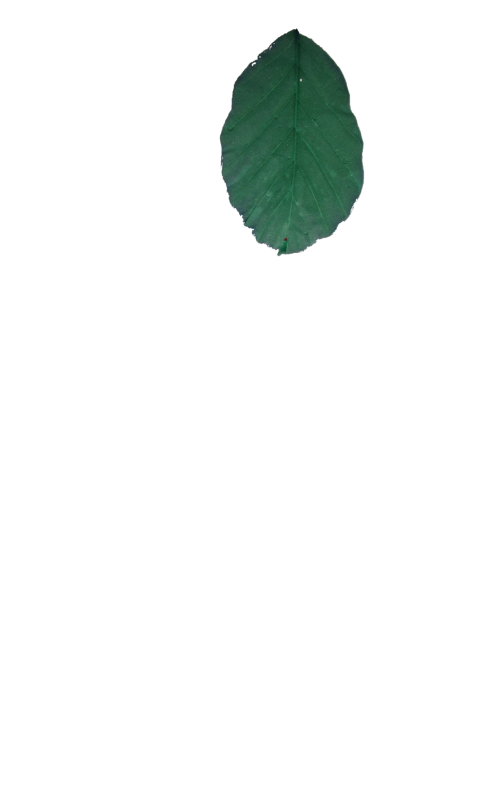

In [194]:
plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(smoothed)
plt.axis('off')
plt.show()